## 1. Connection

In [1]:
#%connect(url=https://try.activeeon.com:8443)

Login:  admin
Password:  ············


Connecting to server ...
Connected as 'admin'!


## 2. Runtime environment definition

In [2]:
#%runtime_env(type=docker,image=activeeon/dlm3,mount_host_path=/shared,mount_container_path=/shared,debug=false,verbose=false,force=off)

Saving the runtime environment ...
Done.


## 3. Importing libraries

In [3]:
#%import()
import json
import numpy as np
import pandas as pd
import pickle
import bz2
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from scipy.stats import uniform

from pathlib import Path

Saving 'Python' imports ...
Saved.


## 4. Creating workflow tasks

### 4.1 Creating the _import_data_ task

In [4]:
#%task(name=import_data,export=[dataframe_json])
dataset_url = "https://activeeon-public.s3.eu-west-2.amazonaws.com/datasets/vehicle_silhouette_weka_dataset.csv"
dataframe = pd.read_csv(dataset_url)

dataframe_json = dataframe.to_json(orient='split').encode()
compressed_data = bz2.compress(dataframe_json)

Creating a proactive 'Python' task ...
Task 'import_data' created.
Adding default selection script to the proactive task ...
Adding job fork environment to the proactive task ...
Adding exporting variables script ...
Adding 'Python' library imports ...
Done.


### 4.2 Creating the _model_training_ task 

In [5]:
#%task(name=model_training,dep=[import_data],import=[dataframe_json])
dataframe = pd.read_json(dataframe_json, orient='split')

label_column = "vehicle_class"
dataframe_train = dataframe.drop(label_column, axis=1, inplace=False)
dataframe_label = dataframe[label_column]

# Set up the Random Forest algorithm
model = RandomForestClassifier(random_state=random.randint(0,9), n_estimators=25, max_features=6)

alg_name = str(model)
alg_name = alg_name[:alg_name.find('(')]

# Perform model training
print(alg_name, " model training...")
model.fit(dataframe_train, dataframe_label)

# Perform cross validation
print(alg_name, " performing cv...")
cv = KFold(n_splits=10, shuffle=True, random_state=random.randint(0,9))
scores = cross_val_score(model, X=dataframe_train, y=dataframe_label, cv=cv)
print("{} average of {:6f} with std. dev. of {:6f}.".format(alg_name, scores.mean(), scores.std()))

# Save the model to disk
filename = 'models/' + alg_name + '.model'
if 'variables' in globals():
    PA_JOB_ID = int(variables.get("PA_JOB_ID"))
    MODELS_BASE_PATH = '/shared/models/job_id_'+str(PA_JOB_ID)
    Path(MODELS_BASE_PATH).mkdir(parents=True, exist_ok=True)
    filename = MODELS_BASE_PATH + '/' + alg_name + '.model'
    variables.put("MODEL_FILE_PATH", filename)
pickle.dump(model, open(filename, 'wb'))
print(alg_name, " stored model at ", filename)

Changing script language to 'Python' ...
Adding job fork environment to the proactive task ...
Dependence 'import_data'==>'model_training' added.
Adding importing variables script ...
Adding 'Python' library imports ...
Done.


### 5. Visualizing the job pipeline

Plotting ...


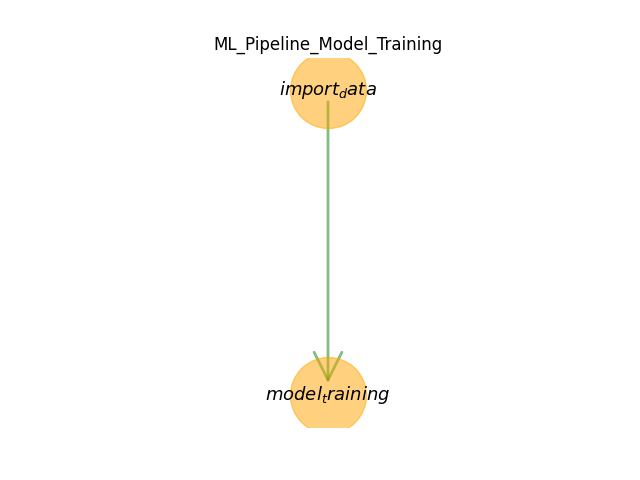

In [6]:
#%draw_job()

### 6. Submitting the job to the scheduler

In [7]:
#%submit_job(name=ML_Pipeline_Model_Training)

Re-creating the proactive job due to tasks changes ...
Saving job variables and generic information ...
Job 'ML_Pipeline_Model_Training' created.
Adding the created tasks to 'ML_Pipeline_Model_Training' ...
Adding generic information ...
Adding variables ...
Done.
Submitting the job to the proactive scheduler ...
job_id: 1


*Generated workflow after job submission*

<img src="images/workflow_model_training.png" alt="drawing" style="width:250px;"/>

### 7. Getting results and outputs 

In [8]:
#%print_job_output

Getting job 1 console outputs ...
Outputs:

RandomForestClassifier  model training...
RandomForestClassifier  performing cv...
RandomForestClassifier  average of 0.748333 with std. dev. of 0.041873.
RandomForestClassifier  stored model at  /shared/models/job_id_1/RandomForestClassifier.model